# Analysis of Processed Experimental Data

This notebook is a resource for comparing multiple replicates of the same tumor-tcell simulation and multiple conditions against each other with statistics

In [1]:
#Import Packages
#Needed for moving to output
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as pl

#Analysis tumor-tcell modules needed
from tumor_tcell.library.population_plots import death_group_plot
from tumor_tcell.library.population_plots import population_group_plot

The imput variables are:
* experiment_dir - these are the directories that contain the replicates of the simulations
* experiment_name - this is what the analysis folder will be called

In [2]:
#Input variables
experiment_dir = ['25% PD1+/','75% PD1+/','No T cells/']
experiment_name = '25vs75vsCntrl_line'

Default states and dictionary that do not need to be changed usually

In [3]:
#Save variables in looping dictionary order for correcting later
conditions_list = [i.split("/", 1)[0] for i in experiment_dir]

#Experiment number
exp_dict = {i: conditions_list[i] for i in range(0, len(conditions_list), 1)}

#Cell types
cell_dict = {0:'Tumor', 1:'T Cell'}

#Cell States
cell_states_tcell = ['PD1n','PD1p']
cell_states_tumor = ['PDL1n','PDL1p']
cell_states = [cell_states_tumor,cell_states_tcell]

#Sets the dash sytle based on the cell state compared
style_dict = {
    cell_states_tumor[0]:'',
    cell_states_tumor[1]:(4,4),
    cell_states_tcell[0]:'',
    cell_states_tcell[1]:(4,4),
}

analysis_dir and save_dir can be changed based on local directory structure. 

This set of code extracts all relevant data and makes a list of dataframes plot_data_list and death_data_list for further processing.

In [4]:
#Get csv saved in experiment id library
analysis_dir = '/mnt/c/Users/akoya-stanford/Python_Code/tumor-tcell/out/analysis/'
save_dir = analysis_dir+'Multiple_analysis/'

#Make new output analysis folder with Experiment Name
analysis_out_dir = save_dir + experiment_name 
os.makedirs(analysis_out_dir, exist_ok=True)

#make into a list for looping
analysis_dir_list=[]
for exp in experiment_dir:
    add_dir = analysis_dir+exp
    analysis_dir_list.append(add_dir)

#Create a list of dataframes for concatenation
plot_data_list = []  
death_data_list = []  

#Loop through directories containing replicates of experimental condition
for exp_dir in analysis_dir_list:
    os.chdir(exp_dir)
    experiment_list = next(os.walk('.'))[1]
    
    plot_list = []
    death_list = []
    df_tumor_death_list = []
    df_tcell_death_list = []
    tumor_plot_list = []
    tcell_plot_list = []
    
    #Loop through experiments
    for experiment in experiment_list:
        experiment_directory = exp_dir+experiment
        os.chdir(experiment_directory)
        
        #Import all the plot and death files into a list of dataframes
        file_list = os.listdir()
        #For control conditions that do not have t cells need if statement
        if 'tcell_plot.csv' in file_list:
            df_tumor_death = pd.read_csv('tumor_death.csv')
            df_tumor_death_list.append(df_tumor_death)

            tumor_plot = pd.read_csv('tumor_plot.csv')
            tumor_plot_list.append(tumor_plot)

            df_tcell_death = pd.read_csv('tcell_death.csv')
            df_tcell_death_list.append(df_tcell_death)

            tcell_plot = pd.read_csv('tcell_plot.csv')
            tcell_plot_list.append(tcell_plot)
            
        else:
            df_tumor_death = pd.read_csv('tumor_death.csv')
            df_tumor_death_list.append(df_tumor_death)

            tumor_plot = pd.read_csv('tumor_plot.csv')
            tumor_plot_list.append(tumor_plot)
    
    #Make 2 lists for different cell types
    plot_list.extend([tumor_plot_list,tcell_plot_list])
    death_list.extend([df_tumor_death_list,df_tcell_death_list])
    
    #Make a new upper list based on experimental condition and do one for cells and death data
    plot_data_list.append(plot_list)
    death_data_list.append(death_list)

plot_data_list[0]    

[[        Unnamed: 0       time                  cell cell_state      IFNg  \
  0                0   0.000000               tumor_0      PDL1p  0.000000   
  1                1   0.000000               tumor_1      PDL1n  0.000000   
  2                2   0.000000               tumor_2      PDL1n  0.000000   
  3                3   0.000000               tumor_3      PDL1n  0.000000   
  4                4   0.000000               tumor_4      PDL1p  0.000000   
  ...            ...        ...                   ...        ...       ...   
  584598      584598  73.333333        tumor_294BAAAA      PDL1n  0.000269   
  584599      584599  73.333333       tumor_294BAAABA      PDL1n  0.000269   
  584600      584600  73.333333       tumor_294BAAABB      PDL1n  0.000269   
  584601      584601  73.333333  tumor_966AAAAAABBBAA      PDL1n  0.000762   
  584602      584602  73.333333  tumor_966AAAAAABBBAB      PDL1n  0.000428   
  
          cytotoxic_packets           X           Y  \
  0   

This next set of code loops through the dataframes to perform statistics on the replicates and generates a list of dataframes cell_plot_list as output based on the number of experiments to compare

In [5]:
cell_plot_list = []
#loop through experiments
for exp in range(len(plot_data_list)):
    df_list_plot = []
    exp_df = plot_data_list[exp]
    #loop through cells
    for cell in range(len(exp_df)):
        cell_state_list_1 = []
        cell_state_list_2 = []
        total_list = []
        cell_list = []
        cell_df = exp_df[cell]
        
        #need condition for control samples
        if len(cell_df)==0:
            continue
            
        else:
            #Count the unique cells and individual cell states for each experiment
            for i in range(len(cell_df)):
                #get unique cells
                total_cell = cell_df[i].groupby(['time','experiment_id'])['cell'].nunique().reset_index()
                total_list.append(total_cell)

                cell_state_df = cell_df[i].groupby(['time', 'cell_state','experiment_id'])['cell'].nunique().reset_index()
                state_1 = cell_state_df.loc[cell_state_df['cell_state'] == cell_states[cell][0]]
                cell_state_list_1.append(state_1)

                state_2 = cell_state_df.loc[cell_state_df['cell_state'] == cell_states[cell][1]]
                cell_state_list_2.append(state_2)

            df_total = pd.concat(total_list)
            df_state_1 = pd.concat(cell_state_list_1)
            df_state_2 = pd.concat(cell_state_list_2)
        
        #Get the mean and sem for each condition
        df_total_ave = df_total.groupby(['time']).agg({'cell': ['mean', 'sem']})
        df_total_ave.columns = df_total_ave.columns.droplevel(0)
        df_total_ave = df_total_ave.rename_axis(None, axis=1)
        df_total_ave.reset_index(inplace=True)
        
        
        df_state_1_ave = df_state_1.groupby(['time','cell_state']).agg({'cell': ['mean', 'sem']})
        df_state_1_ave.columns = df_state_1_ave.columns.droplevel(0)
        df_state_1_ave = df_state_1_ave.rename_axis(None, axis=1)
        df_state_1_ave.reset_index(inplace=True)
    
        df_state_2_ave = df_state_2.groupby(['time','cell_state']).agg({'cell': ['mean', 'sem']})
        df_state_2_ave.columns = df_state_2_ave.columns.droplevel(0)
        df_state_2_ave = df_state_2_ave.rename_axis(None, axis=1)
        df_state_2_ave.reset_index(inplace=True)
        
        cell_state_all = pd.concat([df_state_1_ave, df_state_2_ave])
        #save both the total and cell_state df in list
        cell_list.append(df_total_ave)
        cell_list.append(cell_state_all)
        #save in another list based on cells
        df_list_plot.append(cell_list)
    #save in another list based on experiment
    cell_plot_list.append(df_list_plot)
        
cell_plot_list

[[[          time     mean         sem
   0     0.000000  1200.00    0.000000
   1     0.166667  1202.75    0.750000
   2     0.333333  1208.50    1.443376
   3     0.500000  1210.75    1.493039
   4     0.666667  1212.50    2.101587
   ..         ...      ...         ...
   436  72.666667  1926.00  420.098996
   437  72.833333  1929.50  422.285942
   438  73.000000  1937.50  425.571283
   439  73.166667  1941.75  428.158922
   440  73.333333  1945.00  430.793067
   
   [441 rows x 3 columns],
             time cell_state    mean        sem
   0     0.000000      PDL1n  607.75  14.366483
   1     0.166667      PDL1n  611.25  14.699065
   2     0.333333      PDL1n  617.00  15.367715
   3     0.500000      PDL1n  619.50  15.080340
   4     0.666667      PDL1n  622.00  15.753307
   ..         ...        ...     ...        ...
   436  72.666667      PDL1p  864.50  34.731110
   437  72.833333      PDL1p  862.75  35.034209
   438  73.000000      PDL1p  862.00  34.645827
   439  73.166667    

This set of code produces the plot that shows the mean and sem for the various population plots

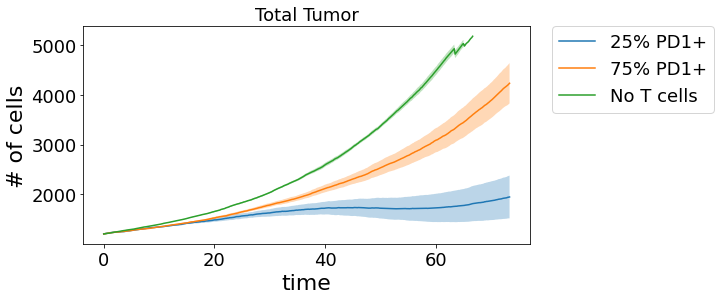

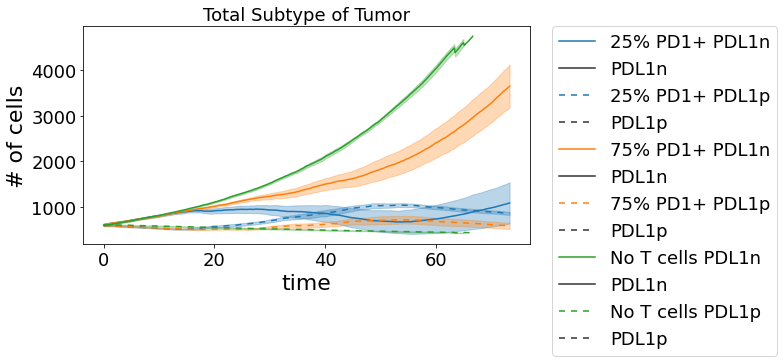

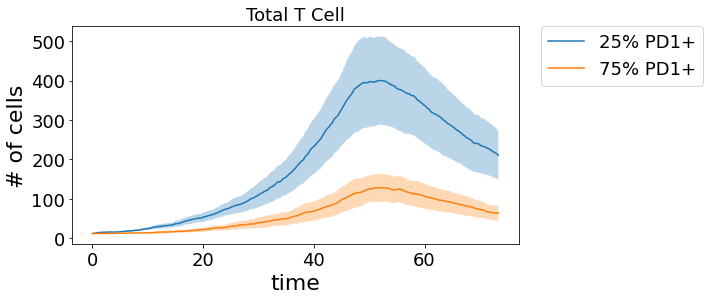

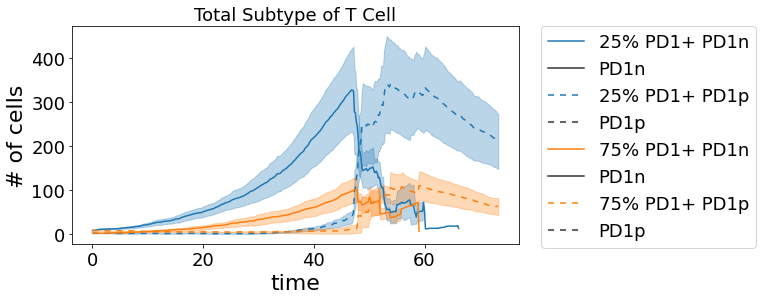

In [6]:
#Sets the color style based on number of experiments compared
color_dict = {}
for exp in range(len(cell_plot_list)):
    color_dict[exp]=sns.color_palette()[exp]

#loop first based on the cell type
for cell in range(len(cell_plot_list[0])):
    
    SMALL_SIZE = 18
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 24

    pl.rc('font', size=SMALL_SIZE)  # controls default text sizes
    pl.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    pl.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    pl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # Create plot
    pl.figure(figsize=(8, 4))

    #loop next based on experiment
    for exp in range(len(cell_plot_list)): 
        
        #need for control condition
        if len(cell_plot_list[exp])==1 & cell>0:
            continue
        #Create plot for each experiment per cell type
        else:
            df_plot = cell_plot_list[exp][cell][0]

            # create vectors to use for SEM plotting
            M_new_vec = np.array(df_plot['mean'])
            Sigma_new_vec = np.array(df_plot['sem'])
            lower_bound = M_new_vec - Sigma_new_vec
            upper_bound = M_new_vec + Sigma_new_vec

            # Create plot
            ttl_1 = sns.lineplot(data=df_plot, x="time", y='mean', label=exp_dict[exp])
            pl.title("Total " + str(cell_dict[cell]))
            pl.ylabel('# of cells')
            pl.fill_between(df_plot['time'], lower_bound, upper_bound, alpha=.3)
            pl.legend(title="Experiment")
            pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    pl.savefig(analysis_out_dir + '/' + cell_dict[cell] + '_cell_total.png', transparent=True, format='png',
               bbox_inches='tight', dpi=300)
        
    # Create plot
    pl.figure(figsize=(8, 4))

    for exp in range(len(cell_plot_list)):    
        if len(cell_plot_list[exp])==1 & cell>0:
            continue
        else:
            df_plot = cell_plot_list[exp][cell][1]

            #loop through each state to look at substates of the cells
            for state in df_plot.cell_state.unique():
                # create vectors to use for SEM plotting
                df_state = df_plot[df_plot.cell_state==state]
                M_new_vec = np.array(df_state['mean'])
                Sigma_new_vec = np.array(df_state['sem'])
                lower_bound = M_new_vec - Sigma_new_vec
                upper_bound = M_new_vec + Sigma_new_vec

                # Create plot
                ttl_2 = sns.lineplot(data=df_state, x="time", y='mean',label=exp_dict[exp]+' '+state,\
                                    color=color_dict[exp], style='cell_state',dashes=style_dict)
                pl.title("Total Subtype of " + cell_dict[cell])
                pl.ylabel('# of cells')
                pl.fill_between(df_state['time'], lower_bound, upper_bound, alpha=.3, color=color_dict[exp])
                pl.legend(title="Experiment")
                pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    pl.savefig(analysis_out_dir + '/' + cell_dict[cell] + '_cell_subtypes.png', transparent=True, format='png',
               bbox_inches='tight', dpi=300)

This next set of code loops through the dataframes to perform statistics on the replicates and generates a list of dataframes death_plot_list as output based on the number of experiments to compare death statistics

In [7]:
death_plot_list = []
#loop through experiments
for exp in range(len(death_data_list)):
    death_list_plot = []
    exp_df = death_data_list[exp]
    
    #loop through cell types
    for cell in range(len(exp_df)):
        death_cell_list = []
        death_plot_l = []
        other_death_plot_l =[]
        cell_df = exp_df[cell]
        
        #need for control condition (no T cells)
        if len(cell_df)==0:
            continue
            
        else:
        
            for i in range(0,len(cell_df)):    
                #convert the time back to seconds
                cell_df[i]['time_s'] = cell_df[i].time*3600
                cell_df[i].time_s = cell_df[i].time_s.round(-1).astype(int)
                #list of unique death types
                death_types_list = list(cell_df[i]['death'].unique())
                #create a dictionary of death types and map to sum for .agg function
                dict_death = {}
                for death_type in death_types_list:
                    dict_death[death_type] = 'sum'
                #add exp_id to dict dataframe
                dict_death['experiment_id'] = 'first'
                #aggregate to combine multiple cell deaths at the same time point
                death_agg = cell_df[i].groupby('time_s').agg(dict_death)
                #Add in missing intervals (no death)
                death_agg_time = death_agg.reindex(np.arange(0, cell_df[i].time_s.max()+60,60),fill_value=0)
                #change to timeindex so that we can resample the data for better mean and sem calculations by the hour
                death_agg_time.index = pd.to_timedelta(death_agg_time.index, unit='s')
                df_hour = death_agg_time.resample('h').sum()
                for death_type in death_types_list:
                    df_hour['total_' + str(death_type)] = df_hour[death_type].cumsum()
                total_col_t = [col for col in df_hour.columns if 'total' in col]
                df_hour['total_death'] = df_hour[total_col_t].sum(axis=1)
                df_hour['time'] = (df_hour.index.days*24+df_hour.index.seconds/3600)

                #create dataframes for the plotting
                total_col = [col for col in df_hour.columns if 'total' in col]
                death_plot = pd.melt(df_hour, id_vars=[ 'time',], value_vars=total_col)
                death_plot.rename(columns={'variable': 'death type', 'value': 'death count'}, inplace=True)
                death_plot['experiment_id'] = i

                total_death_plot = death_plot.loc[death_plot['death type'] == 'total_death']
                other_death_plot = death_plot.loc[~(death_plot['death type'] == 'total_death')]

                death_plot_l.append(total_death_plot)
                other_death_plot_l.append(other_death_plot)

        # Concatenate all
        death_plots = pd.concat(death_plot_l)
        other_death_plots = pd.concat(other_death_plot_l)

        # Get mean and sem for each
        total_death_plot_ave = death_plots.groupby('time').agg({'death count': ['mean', 'sem']})
        total_death_plot_ave.columns = total_death_plot_ave.columns.droplevel(0)
        total_death_plot_ave = total_death_plot_ave.rename_axis(None, axis=1)
        total_death_plot_ave.reset_index(inplace=True)
        
        other_death_plot_ave = other_death_plots.groupby(['time','death type']).agg({'death count': ['mean', 'sem']})
        other_death_plot_ave.columns = other_death_plot_ave.columns.droplevel(0)
        other_death_plot_ave = other_death_plot_ave.rename_axis(None, axis=1)
        other_death_plot_ave.reset_index(inplace=True)

        death_cell_list.append(total_death_plot_ave)
        death_cell_list.append(other_death_plot_ave)
        death_list_plot.append(death_cell_list)
    
    death_plot_list.append(death_list_plot)
        
death_plot_list

[[[    time     mean        sem
   0    0.0     4.75   0.946485
   1    1.0    14.00   0.912871
   2    2.0    30.25   2.657536
   3    3.0    42.75   2.594064
   4    4.0    53.50   2.753785
   ..   ...      ...        ...
   69  69.0  1491.50  27.167689
   70  70.0  1508.25  31.084227
   71  71.0  1528.00  34.056326
   72  72.0  1545.50  36.906413
   73  73.0  1550.75  36.867725
   
   [74 rows x 3 columns],
        time         death type    mean        sem
   0     0.0  total_Tcell_death    0.00   0.000000
   1     0.0    total_apoptosis    4.75   0.946485
   2     1.0  total_Tcell_death    3.00   0.912871
   3     1.0    total_apoptosis   11.00   0.408248
   4     2.0  total_Tcell_death   11.00   1.957890
   ..    ...                ...     ...        ...
   143  71.0    total_apoptosis  663.25  52.647214
   144  72.0  total_Tcell_death  872.50  31.322250
   145  72.0    total_apoptosis  673.00  55.291651
   146  73.0  total_Tcell_death  874.25  31.639572
   147  73.0    total_apo

This set of code produces the plot that shows the mean and sem for the various population plots

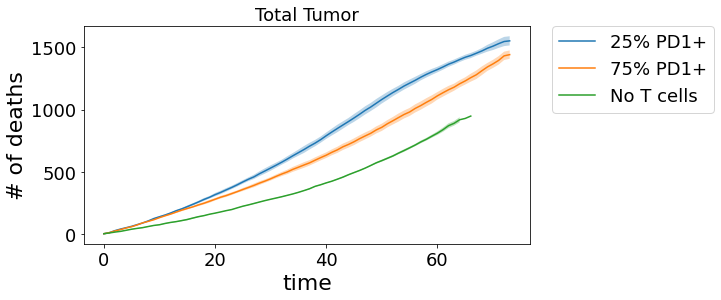

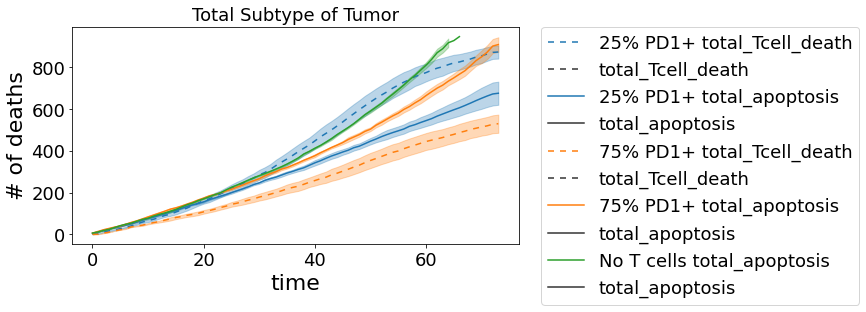

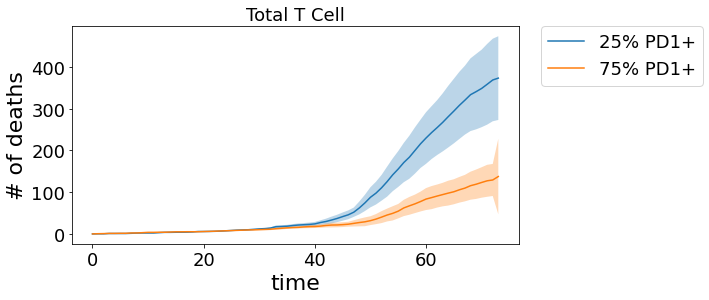

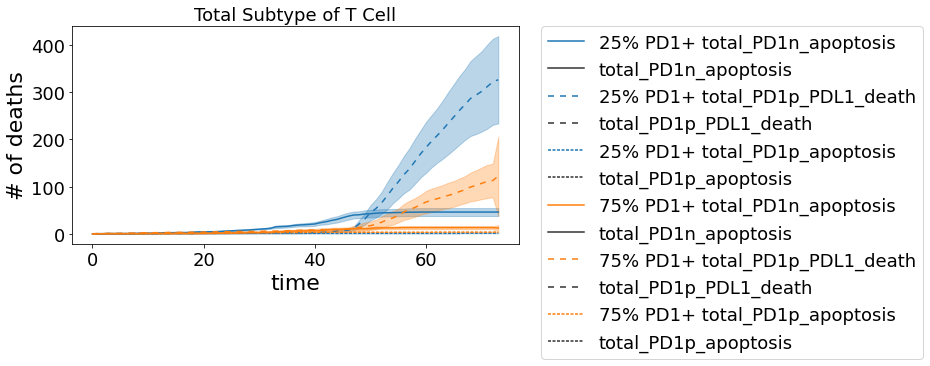

In [8]:
#Set the death style dictionary for discriminating the death types
death_style_dict = {
    'total_apoptosis':'',
    'total_Tcell_death':(4,4),
    'total_PD1n_apoptosis':'',
    'total_PD1p_apoptosis':(2,1),
    'total_PD1p_PDL1_death':(4,4),
}

#First loop through cell types
for cell in range(len(death_plot_list[0])):

    SMALL_SIZE = 18
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 24

    pl.rc('font', size=SMALL_SIZE)  # controls default text sizes
    pl.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    pl.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    pl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # Create plot
    pl.figure(figsize=(8, 4))

    #Loop through experiments and have condition for control that does not have T cells
    for exp in range(len(death_plot_list)):    
        if len(death_plot_list[exp])==1 & cell>0:
            continue
        else:
        
            df_plot = death_plot_list[exp][cell][0]

            # create vectors to use for SEM plotting
            M_new_vec = np.array(df_plot['mean'])
            Sigma_new_vec = np.array(df_plot['sem'])
            lower_bound = M_new_vec - Sigma_new_vec
            upper_bound = M_new_vec + Sigma_new_vec

            # Create plot
            ttl_1 = sns.lineplot(data=df_plot, x="time", y='mean', label=exp_dict[exp])
            pl.title("Total " + cell_dict[cell])
            pl.ylabel('# of deaths')
            pl.fill_between(df_plot['time'], lower_bound, upper_bound, alpha=.3)
            pl.legend(title="Experiment")
            pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    pl.savefig(analysis_out_dir + '/' + cell_dict[cell]+'_death_total.png', transparent=True, format='png',
               bbox_inches='tight', dpi=300)

    # Create plot
    pl.figure(figsize=(8, 4))

    for exp in range(len(death_plot_list)):    
        if len(death_plot_list[exp])==1 & cell>0:
            continue
        else:
            df_plot = death_plot_list[exp][cell][1]

            for death_type in df_plot['death type'].unique():
                # create vectors to use for SEM plotting
                df_state = df_plot[df_plot['death type']==death_type]
                M_new_vec = np.array(df_state['mean'])
                Sigma_new_vec = np.array(df_state['sem'])
                lower_bound = M_new_vec - Sigma_new_vec
                upper_bound = M_new_vec + Sigma_new_vec

                # Create plot
                ttl_2 = sns.lineplot(data=df_state, x="time", y='mean',label=exp_dict[exp]+' '+death_type,\
                                    color=color_dict[exp], style='death type',dashes=death_style_dict)
                pl.title("Total Subtype of " + cell_dict[cell])
                pl.ylabel('# of deaths')
                pl.fill_between(df_state['time'], lower_bound, upper_bound, alpha=.3, color=color_dict[exp])
                pl.legend(title="Experiment")
                pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    pl.savefig(analysis_out_dir + '/' + cell_dict[cell] + '_death_subtype.png', transparent=True, format='png',
               bbox_inches='tight', dpi=300)       

This set of code generates output for comparison of averages to in vitro or in vivo based experiments

In [9]:
#### Create output for the cell percentages at the end of the simulation to compare with experimental
df_sub_list = []
for cell in range(len(cell_plot_list[1])):

    for exp in range(len(cell_plot_list)): 
        
        if len(cell_plot_list[exp])==1 & cell>0:
            continue
        else:
            dfplot = cell_plot_list[exp][cell][1]
            for state in dfplot.cell_state.unique():
                df_state = dfplot[dfplot.cell_state==state]
                #Get last cell in the dataframe 
                dfsub = df_state.iloc[-1:].copy()
                dfsub['experiment'] = exp_dict[exp]
                dfsub['cell'] = cell_dict[cell]
                df_sub_list.append(dfsub)

df_final_cell_counts = pd.concat(df_sub_list)
df_final_cell_counts.to_csv(analysis_out_dir+'/final_cell_counts.csv')